# About this notebook
- Timm EfficientNetB4_ns
- Alubmentation(Resized,CLAHE,ShiftScaleRotate,Normalize)
- None Filter
- Size 640
- batchsize 16
- Multi-label stratified k-Fold num=5

# Data Loading

In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
os.listdir('./')

['train.log',
 'train.csv',
 'train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'pytorch-image-models-master',
 'test',
 '.ipynb_checkpoints',
 'exp008.ipynb',
 'train']

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./sample_submission.csv')
display(train.head())
display(test.head())

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


# Quick EDA

In [4]:
train['PatientID'].value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
8bed19720      1
05389d25c      1
1951dc11c      1
c1052a560      1
b6bf0195b      1
Name: PatientID, Length: 3255, dtype: int64

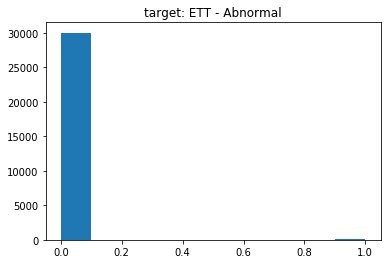

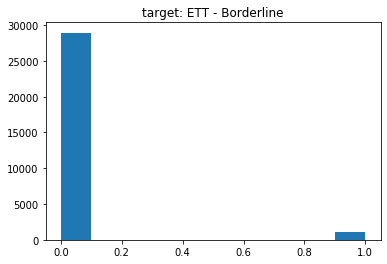

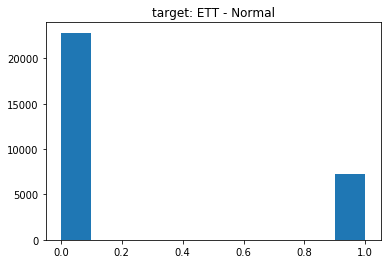

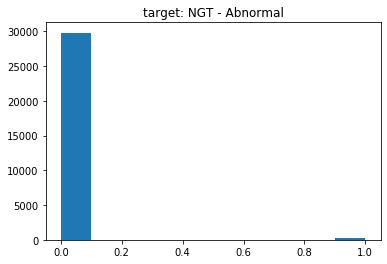

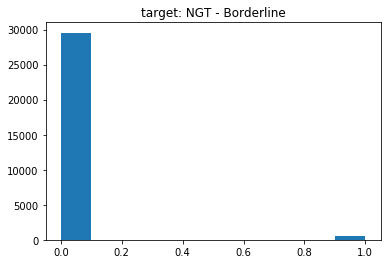

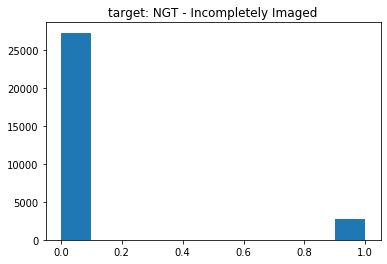

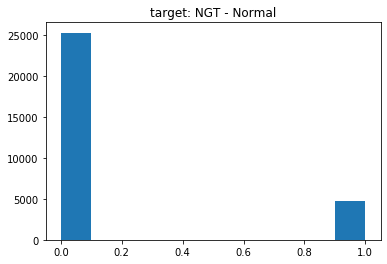

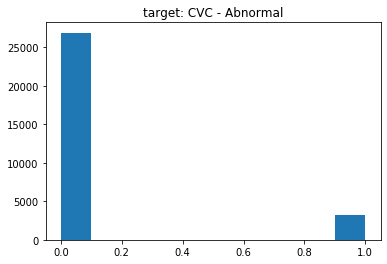

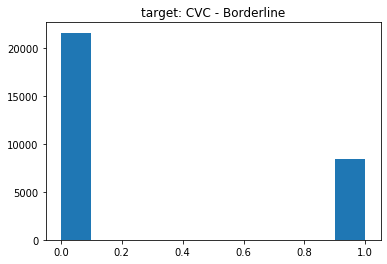

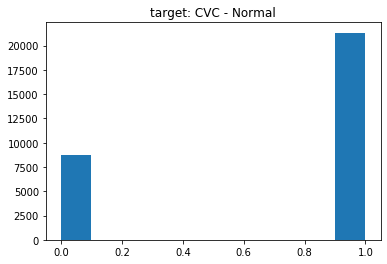

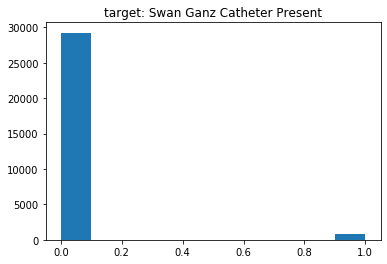

In [5]:
target_cols = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 
               'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
               'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']

for c in target_cols:
    plt.hist(train[c].values)
    plt.title(f'target: {c}')
    plt.show()

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#TRAIN_PATH = '../input/ranzcr-512x512-dataset'
#TRAIN_PATH = '../input/ranzcr-640x640-dataset'
TRAIN_PATH = './train'

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=100
    
    num_workers=8
    model_name= 'tf_efficientnet_b4_ns'#'resnext50_32x4d'
    
    size=640 #512
    
    scheduler='CosineAnnealingLR' 
    # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    
    epochs=6
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    
    batch_size=32
    
    seed=42
    
    target_size=11
    
    target_cols=['ETT - Abnormal',
                 'ETT - Borderline',
                 'ETT - Normal',
                 'NGT - Abnormal',
                 'NGT - Borderline',
                 'NGT - Incompletely Imaged',
                 'NGT - Normal', 
                 'CVC - Abnormal',
                 'CVC - Borderline',
                 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    
    trn_fold=[0, 1, 2, 3, 4]
    n_fold=len(trn_fold)
    
    train=True
    annotation=True
    Filter=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('./pytorch-image-models-master')

import os
import ast
import copy
import gc
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
from scipy.sparse import coo_matrix
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose,
    MotionBlur, MedianBlur, GaussianBlur,
    CLAHE, RandomGamma, OpticalDistortion, HueSaturationValue, RGBShift, ToGray
    
    )
from albumentations.pytorch import ToTensorV2,ToTensor
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU:',device)

GPU: cpu


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [10]:
def multi_label_stratified_group_k_fold(label_arr: np.array, gid_arr: np.array, n_fold: int, seed: int=42):
    """
    create multi-label stratified group kfold indexs.

    reference: https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    input:
        label_arr: numpy.ndarray, shape = (n_train, n_class)
            multi-label for each sample's index using multi-hot vectors
        gid_arr: numpy.array, shape = (n_train,)
            group id for each sample's index
        n_fold: int. number of fold.
        seed: random seed.
    output:
        yield indexs array list for each fold's train and validation.
    """
    np.random.seed(seed)
    random.seed(seed)
    start_time = time.time()
    n_train, n_class = label_arr.shape
    gid_unique = sorted(set(gid_arr))
    n_group = len(gid_unique)

    # # aid_arr: (n_train,), indicates alternative id for group id.
    # # generally, group ids are not 0-index and continuous or not integer.
    gid2aid = dict(zip(gid_unique, range(n_group)))
#     aid2gid = dict(zip(range(n_group), gid_unique))
    aid_arr = np.vectorize(lambda x: gid2aid[x])(gid_arr)

    # # count labels by class
    cnts_by_class = label_arr.sum(axis=0)  # (n_class, )

    # # count labels by group id.
    col, row = np.array(sorted(enumerate(aid_arr), key=lambda x: x[1])).T
    cnts_by_group = coo_matrix(
        (np.ones(len(label_arr)), (row, col))
    ).dot(coo_matrix(label_arr)).toarray().astype(int)
    del col
    del row
    cnts_by_fold = np.zeros((n_fold, n_class), int)

    groups_by_fold = [[] for fid in range(n_fold)]
    group_and_cnts = list(enumerate(cnts_by_group))  # pair of aid and cnt by group
    np.random.shuffle(group_and_cnts)
    print("finished preparation", time.time() - start_time)
    for aid, cnt_by_g in sorted(group_and_cnts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for fid in range(n_fold):
            # # eval assignment.
            cnts_by_fold[fid] += cnt_by_g
            fold_eval = (cnts_by_fold / cnts_by_class).std(axis=0).mean()
            cnts_by_fold[fid] -= cnt_by_g

            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = fid

        cnts_by_fold[best_fold] += cnt_by_g
        groups_by_fold[best_fold].append(aid)
    print("finished assignment.", time.time() - start_time)

    gc.collect()
    idx_arr = np.arange(n_train)
    for fid in range(n_fold):
        val_groups = groups_by_fold[fid]

        val_indexs_bool = np.isin(aid_arr, val_groups)
        train_indexs = idx_arr[~val_indexs_bool]
        val_indexs = idx_arr[val_indexs_bool]

        print("[fold {}]".format(fid), end=" ")
        print("n_group: (train, val) = ({}, {})".format(n_group - len(val_groups), len(val_groups)), end=" ")
        print("n_sample: (train, val) = ({}, {})".format(len(train_indexs), len(val_indexs)))

        yield train_indexs, val_indexs

In [11]:
label_arr = train[CFG.target_cols].values
group_id = train.PatientID.values

train_val_indexs = \
list(multi_label_stratified_group_k_fold(label_arr, group_id, CFG.n_fold, CFG.seed))

finished preparation 0.05165457725524902
finished assignment. 0.5899703502655029
[fold 0] n_group: (train, val) = (2604, 651) n_sample: (train, val) = (24084, 5999)
[fold 1] n_group: (train, val) = (2601, 654) n_sample: (train, val) = (24104, 5979)
[fold 2] n_group: (train, val) = (2603, 652) n_sample: (train, val) = (24000, 6083)
[fold 3] n_group: (train, val) = (2605, 650) n_sample: (train, val) = (24131, 5952)
[fold 4] n_group: (train, val) = (2607, 648) n_sample: (train, val) = (24013, 6070)


In [12]:
folds = train.copy()

for n, (train_index, val_index) in enumerate(train_val_indexs):
    folds.loc[val_index, "fold"] = int(n)
    
folds.groupby('fold')[CFG.target_cols].sum()

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
fold,,,,,,,,,,,
0.0,15,228,1448,55,105,550,960,639,1692,4265,166
1.0,16,228,1448,56,106,550,960,639,1692,4265,166
2.0,16,227,1448,56,106,550,959,639,1692,4265,166
3.0,16,228,1448,56,106,549,959,639,1692,4265,166
4.0,16,227,1448,56,106,549,959,639,1692,4264,166


# Dataset

In [13]:
train_annotations = pd.read_csv(
    './train_annotations.csv')

'''
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }
'''

COLOR_MAP = {'ETT - Abnormal': (0, 0, 0),
             'ETT - Borderline': (0, 0, 0),
             'ETT - Normal': (0, 0, 0),
             'NGT - Abnormal': (0, 0, 0),
             'NGT - Borderline': (0, 0, 0),
             'NGT - Incompletely Imaged': (0, 0, 0),
             'NGT - Normal': (0, 0, 0),
             'CVC - Abnormal': (0, 0, 0),
             'CVC - Borderline': (0, 0, 0),
             'CVC - Normal': (0, 0, 0),
             'Swan Ganz Catheter Present': (0, 0, 0),
            }


In [14]:
'''
# ハイパス フィルタ
adapted_filter = np.array([[-1, -1, -1],
                           [-1,  8, -1],
                           [-1, -1, -1]],np.float32)

# グラディエント フィルタ（３ｘ３）
adapted_filter = np.array([[ 1,  1,  1],
                           [ 0,  0,  0],
                           [-1, -1, -1]], np.float32)

# ラプラシアン フィルタ（３×３）
adapted_filter = np.array([[1,  1, 1],
                           [1, -8, 1],
                           [1,  1, 1]], np.float32)

# シャープ化フィルタリング
# シャープの度合い
k = 10.0
# シャープ化するためのオペレータ
adapted_filter = np.array([[0, -k, 0],
                           [-k, 1 +4*k, -k],
                           [0, -k, 0]])
'''

def highpass_filter(src, a = 0.5):
    # 高速フーリエ変換(2次元)
    src = np.fft.fft2(src)
    
    # 画像サイズ
    h, w = src.shape
    
    # 画像の中心座標
    cy, cx =  int(h/2), int(w/2)
    
    # フィルタのサイズ(矩形の高さと幅)
    rh, rw = int(a*cy), int(a*cx)

    # 第1象限と第3象限、第1象限と第4象限を入れ替え
    fsrc =  np.fft.fftshift(src)  

    # 入力画像と同じサイズで値0の配列を生成
    fdst = fsrc.copy()

    # 中心部分だけ0を代入（中心部分以外は元のまま）
    #fdst[cy-rh:cy+rh, cx-rw:cx+rw] = 0
    
    # mask
    mask = np.zeros((h,w))
    cv2.circle(mask,(cx,cy),int(min(h,w)*a),255,-1,lineType=cv2.LINE_8)
    fdst[mask != 0] = 0
    
    # 第1象限と第3象限、第1象限と第4象限を入れ替え(元に戻す)
    fdst =  np.fft.fftshift(fdst)

    # 高速逆フーリエ変換 
    dst = np.fft.ifft2(fdst)
    
    # 実部の値のみを取り出し、符号なし整数型に変換して返す
    return  np.uint8(dst.real)

In [15]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, df_annotations=0, annot_size=30, transform=False, train_flag=False):
        self.df = df
        self.df_annotations = df_annotations
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        self.train = train_flag
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg' # png
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    
        if self.transform:
            aug_prob = random.random()
            # フィルタ
            if CFG.Filter and aug_prob < 0.5:
                #image = cv2.filter2D(image, -1, adapted_filter)
                # ハイパスフィルタ処理
                image = highpass_filter(image, 0.02)
            
                # バイ-ラテラルフィルタ
                #image = cv2.bilateralFilter(image,9,75,75)
            
                # ガウシアンフィルタ
                #image = cv2.GaussianBlur(image,(5,5),0)
                #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
            if CFG.annotation and self.train == True and file_name in self.df_annotations['StudyInstanceUID'].unique() and aug_prob < 0.6:
                query_string = f"StudyInstanceUID == '{file_name}'"
                df = self.df_annotations.query(query_string)
            
                for i, row in df.iterrows():
                    label = row["label"]
                    data = np.array(ast.literal_eval(row["data"]))
                
                    for d in data:
                        image[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                              d[0]-self.annot_size//2:d[0]+self.annot_size//2,
                              :] = COLOR_MAP[label]
            
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [16]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 0.90), ratio=(0.90,1.0)),
            #OneOf([RandomBrightness(limit=(-0.1,0.1)),
            #       RandomContrast(limit=(-0.1,0.1))],
            #      p=0.5,),
            #OneOf([MotionBlur(blur_limit=3),
            #       MedianBlur(blur_limit=3),
            #       GaussianBlur(blur_limit=3),],
            #      p=0.5,),
            #HorizontalFlip(p=0.5),
            
            CLAHE(clip_limit=40.0, tile_grid_size=(8, 8), p=0.5),
            #OneOf([CLAHE(clip_limit=40.0, tile_grid_size=(4, 4),p=1), CLAHE(clip_limit=100.0, tile_grid_size=(8, 8),p=1)],p=1),
            #RandomGamma(gamma_limit=(80, 120), p=1),
            #OpticalDistortion(distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, p=1),
            #HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
            #RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=50, p=1),
            #RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            #ToGray(p=1),
            
            Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],),
            ShiftScaleRotate(shift_limit=(-0.05,0.05),
                             scale_limit=(-0.05,0.05),
                             rotate_limit=(-5,5),
                             interpolation=cv2.INTER_LINEAR,
                             border_mode=cv2.BORDER_REFLECT_101,
                             p=0.5),
            #Rotate(limit=(-5,5),interpolation=cv2.INTER_LINEAR,border_mode=cv2.BORDER_REFLECT_101,),
            ToTensorV2(),
            #ToTensor(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],),
            ToTensorV2(),
            #ToTensor(),
        ])

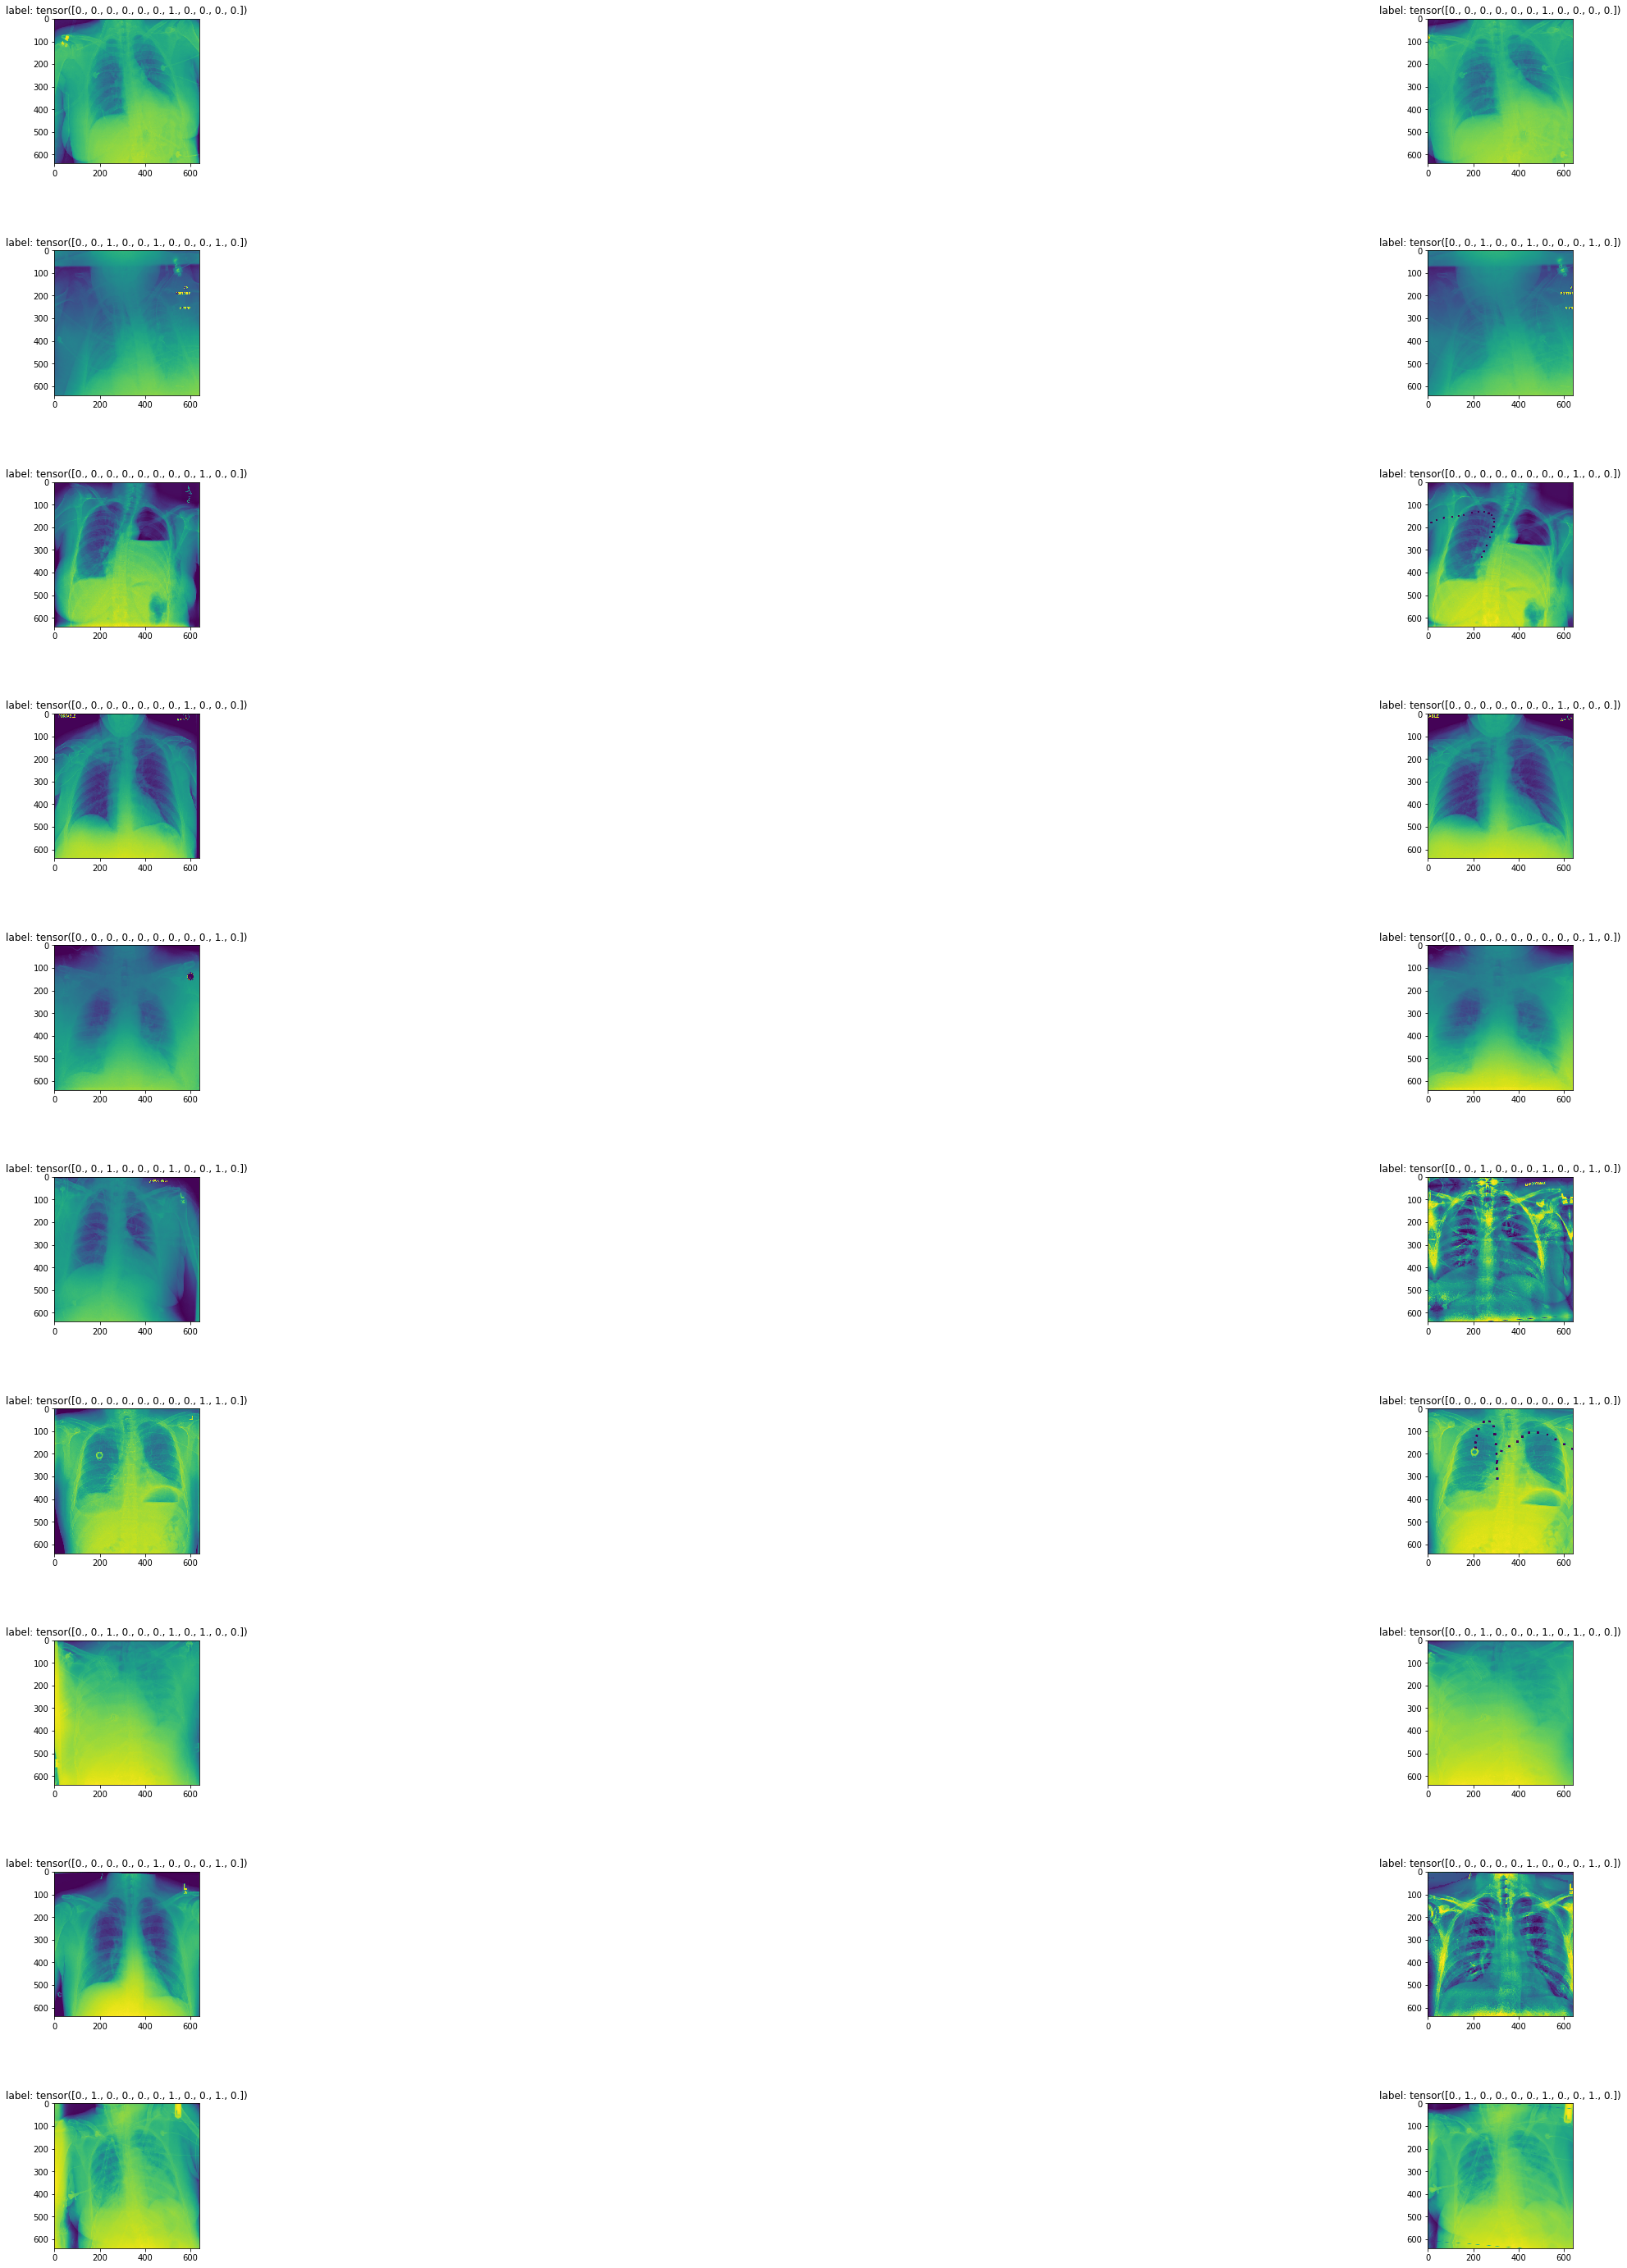

In [17]:
# CHECK Image

#if CFG.annotation:
#    valid_dataset = \
#    TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
#                 df_annotations=train_annotations,
#                 transform=get_transforms(data='valid'))
    
#    train_dataset = \
#    TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
#                 df_annotations=train_annotations,
#                 transform=get_transforms(data='train'))
#else:
#    valid_dataset = TrainDataset(train,transform=get_transforms(data='valid'))
#    train_dataset = TrainDataset(train,transform=get_transforms(data='train'))

valid_dataset = TrainDataset(train,
                             df_annotations=train_annotations,
                             transform=get_transforms(data='valid'),
                             train_flag=False)
train_dataset = TrainDataset(train,
                             df_annotations=train_annotations,
                             transform=get_transforms(data='train'),
                             train_flag=True)

#plt.figure(figsize=(20,20))
#plt.subplots_adjust(wspace=0.5, hspace=0.6)
figure, ax = plt.subplots(10, 2)
plt.subplots_adjust(wspace=0.5,hspace=0.6)

for i in range(10):
        
    image1, label1 = valid_dataset[i]
    #print(image1.shape)
    ax[i,0].imshow(image1[0,:,:])
    #ax[i,0].imshow(image1,'gray')
    #ax[i,0].imshow(image1)
    ax[i,0].set_title(f'label: {label1}')
        
    image2, label2 = train_dataset[i]
    #print(image2.shape)
    #ax[i,1].imshow(image2,'gray')
    ax[i,1].imshow(image2[0,:,:])
    #ax[i,1].imshow(image2)
    ax[i,1].set_title(f'label: {label2}')

figure.set_size_inches(50, 50)
plt.show();

# MODEL

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained)
        if model_name=='resnext50_32x4d':
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG.target_size)
        else:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    print(image.shape)
    output = model(image)
    print(output.shape)
    print(output)
    break

torch.Size([4, 3, 640, 640])
torch.Size([4, 11])
tensor([[ 0.0390,  0.0363, -0.0130, -0.0076,  0.0410, -0.0193, -0.0408,  0.0179,
         -0.0523, -0.0464, -0.1114],
        [ 0.0444, -0.0037, -0.0488, -0.0305,  0.0172, -0.0425, -0.0393,  0.0107,
         -0.0469, -0.0313, -0.1001],
        [-0.0964,  0.1264,  0.0463, -0.0188, -0.0150, -0.0529, -0.0920,  0.0508,
         -0.1503, -0.0759, -0.1862],
        [-0.6357,  0.2741,  0.2750, -0.0105, -0.2576,  0.0243, -0.1375,  0.0620,
         -0.5485,  0.0102, -0.3873]], grad_fn=<AddmmBackward>)


# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    if CFG.annotation:
        train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
        valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
        valid_labels = valid_folds[CFG.target_cols].values
        
        train_dataset = TrainDataset(train_folds,
                                     train_annotations,
                                     transform=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds,
                                     train_annotations,
                                     transform=get_transforms(data='valid'))
    
    else:
        valid_labels = valid_folds[CFG.target_cols].values
        train_dataset = TrainDataset(train_folds, 
                                     transform=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, 
                                     transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    #optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.9)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():
    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
                
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
